In [1]:
from Bio import Entrez

In [2]:
# In order to import from the python file without hassle, we add the current
# directory to the python path
import sys; sys.path.append(".")

Let's let the nice folks at NCBI know who we are.

In [3]:
Entrez.email = "mi6568@fri.uni-lj.si"

# How is SARS-CoV-2 spreading?

In the previous homework, we saw that we can infer how closely related different viruses are to one another by constructing pyhlogenetic trees. We know from biology and the theory of evolution that, if the organism are related to one another, they probably shared a common ancestor at some point in the past. The branching structure of the dendrograms hints at the possible time-frame of evolutionary distances between viruses.

Why not apply this same logic to a single, rapidly-mutating virus? SARS-CoV-2 is a RNA virus and mutates at a much faster rate than DNA-based organisms since it lacks many of the proof-reading and correction machinery that DNA-based organisms have. Could we trace the evolutionary path of this pesky virus from the time it was first reported to now by looking at different instances of SARS-CoV-2? Has it mutated in any major way? Is mutation related to geography? After all, if we're sick, we infect people close to us, so will we find that the virus went in a different evolutionary direction in different countries, continents? Let this be our motivation for this homework assignment.

![](https://images.theconversation.com/files/329931/original/file-20200423-47832-10m83yi.jpg?ixlib=rb-1.1.0&rect=17%2C8%2C726%2C370&q=45&auto=format&w=1000&fit=clip)

## Problem 1: UPGMA

In the previous homework we used hierarchical clustering algorithms implemented in scipy. This time, we will implement one of these clustering algorithms ourselves.

**TASK:** Implement the UPGMA algorithm you learned about in lectures for agglomerative hierarchical clustering in the `UPGMA` function in `helper_functions.py`. Your implementation should return a linkage matrix following the same format as that of `scipy.cluster.hierarchy.linkage`, so we can easily plot the dendrogram using existing scipy utilities. See the [documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.linkage.html) for the exact format. **[10 points]**

Once you have implemented the UPGMA algorithm, proceed to Problem 2.

In [4]:
from helper_functions import UPGMA, jukes_cantor

## Problem 2: Phylogenetic analysis

You are given 108 aligned sequences of SARS-CoV-2 collected at different time points around the world. These sequences were mainly collected around last year, as this provides the cleanest picture of how the virus spread around the world. If we were to repeat this using sequences from this year, we would inevitably have to worry about different variants, which may complicate things. Using the UPGMA algorithm you implemented earlier, plot a dendrogram of the sequences.

The aligned sequences are provided in *data/ncbi-sars-cov-2.fasta* in the fasta format. You can read these files using biopython's `SeqIO.parse`. Each record consists of a header indicating the accession id and the aligned sequence. You will need to use the standard NCBI fetching utilities we used in the previous homework to get metadata for each of the provided sequences.

Each NCBI record contains lots of interesting metadata. For the purposes of this homework, we really need three pieces of information. We need to know when the sequence was collected i.e. the collection date, which host the sequence was collected from e.g. humans, mice, ... (in case the host is not given, we can assume a human host), and where/what country the sequence was collected in. We can also convince ourselves that all the viruses are, in fact, SARS-CoV-2 viruses. All of this information can be found in an NCBI sequence record. Scan through the `record.features` field and search for one with `feature.type == "source"`. This object contains several qualifiers which contain all the required metadata.

**TASK:** We first need to calculate pairwise distances between each of our sequences. We'll do this in the same way as in Homework 2, using Hamming distance i.e. the number of mismatching symbols. This is sometimes also refered to as _genetic distance_. Implement the Jukes-Cantor correction in `helper_functions.py`. Apply the correction to the distances (see below for more information on Jukes-Cantor, you will learn more about this in future lectures). Since the sequences are already aligned, you do not have to perform the time-intensive alignment proceedure. Construct the dendrogram using your UPGMA implementation. Plot the phylogenetic tree using existing scipy utilities and save the resulting dendrogram into `problem2.png`. Label the tree branches using the accession id, the country or continent where the sequence was collected, and the collection date. Do the results make sense? Do you see any geographic grouping? What about grouping based on collection date. Save your answers into the `dendrogram_comments` variable.
**[10 points]** 

Hint: check out `scipy.cluster.hierarchy.dendrogram` to plot the dendrogram. Use `pandas.to_datetime` to parse and work with dates more easily.

**Jukes-Cantor correction**:
Estimating the genetic distance between two sequences is not as straightforward as it may initially seem. For instance, consider two nucleotides AC. Lets imagine this sequence undergoes the following mutations: AC -> CC -> TC -> GC -> TC. And imagine we observed onlt the first sequence i.e. AC and the last sequence TC. What is the distance between these two sequences? Well, AC and TC only differ in the first nucleotide, so their genetic distance must be 1. But, we know from the above transitions that there have actually been four mutations. So our naive estimation of genetic distance systematically underestimates the distance between sequences. One way to correct for this is by using the Jukes-Cantor correction. You can read more about it in the book "Introduction to Computational Genomics" by Cristianini and Hahn in section 5.4.1. But in essence, your job is to correct the distances in the following way. 1 - calculate the Hamming/genetic distance between sequences. 2 - convert these distances to proportions of the sequence length i.e. divide the distances by the lengths of the sequences being compared (in the above example, we would have 1 mutation and sequence length 2, therefore the proportianal distance would be 0.5). 3 - Calculate the correction using d_corrected = -3/4 log (1 - 4/3 d_proportions).

In [5]:
import numpy as np
import pandas as pd
import math
from os import path
from Bio import Entrez, SeqIO
from Bio.SeqRecord import SeqRecord
from scipy.spatial.distance import hamming


def hamming(str1, str2):
    result = 0
    for i, j in zip(str1, str2):
        if i != j:
            result += 1
    return result


def load_records(filename):
    virus_records = []
    for record in SeqIO.parse(filename, "fasta"):
        with Entrez.efetch(db="nucleotide", id=record.id, rettype="gb") as handle:
            data = SeqIO.read(handle, "genbank")

        metadata = []
        for feature in data.features:
            if feature.type == 'source':
                if 'host' in feature.qualifiers:
                    host = feature.qualifiers['host']
                else:
                    host = 'Human'
                collection_date = pd.to_datetime(feature.qualifiers['collection_date'])
                metadata.append([host, collection_date, feature.qualifiers['country']])

        virus_records.append([record.id, metadata, record.seq])
    return virus_records

In [6]:
sarsCov2_records = load_records("data/ncbi-sars-cov-2.fasta")

In [7]:
distances = np.empty([len(sarsCov2_records), len(sarsCov2_records)])
for i in range(len(sarsCov2_records)):
    for j in range(i, len(sarsCov2_records)):
        distance_h = hamming(sarsCov2_records[i][2], sarsCov2_records[j][2])
        distance_p = distance_h / len(sarsCov2_records[i][2])
        distance = jukes_cantor(distance_p)
        distances[i][j] = distances[j][i] = distance
        #print(distance_h, distance_p, distance)

#print(distances)

In [8]:
from scipy.cluster.hierarchy import dendrogram
from matplotlib import pyplot as plt

labels = []
for record in sarsCov2_records:
    accessId = record[0]
    country = record[1][0][2]
    datetime = pd.to_datetime(record[1][0][1])
    labels.append(', '.join([accessId, country[0], str(datetime)]))
                           
distance_matrix = UPGMA(distances)

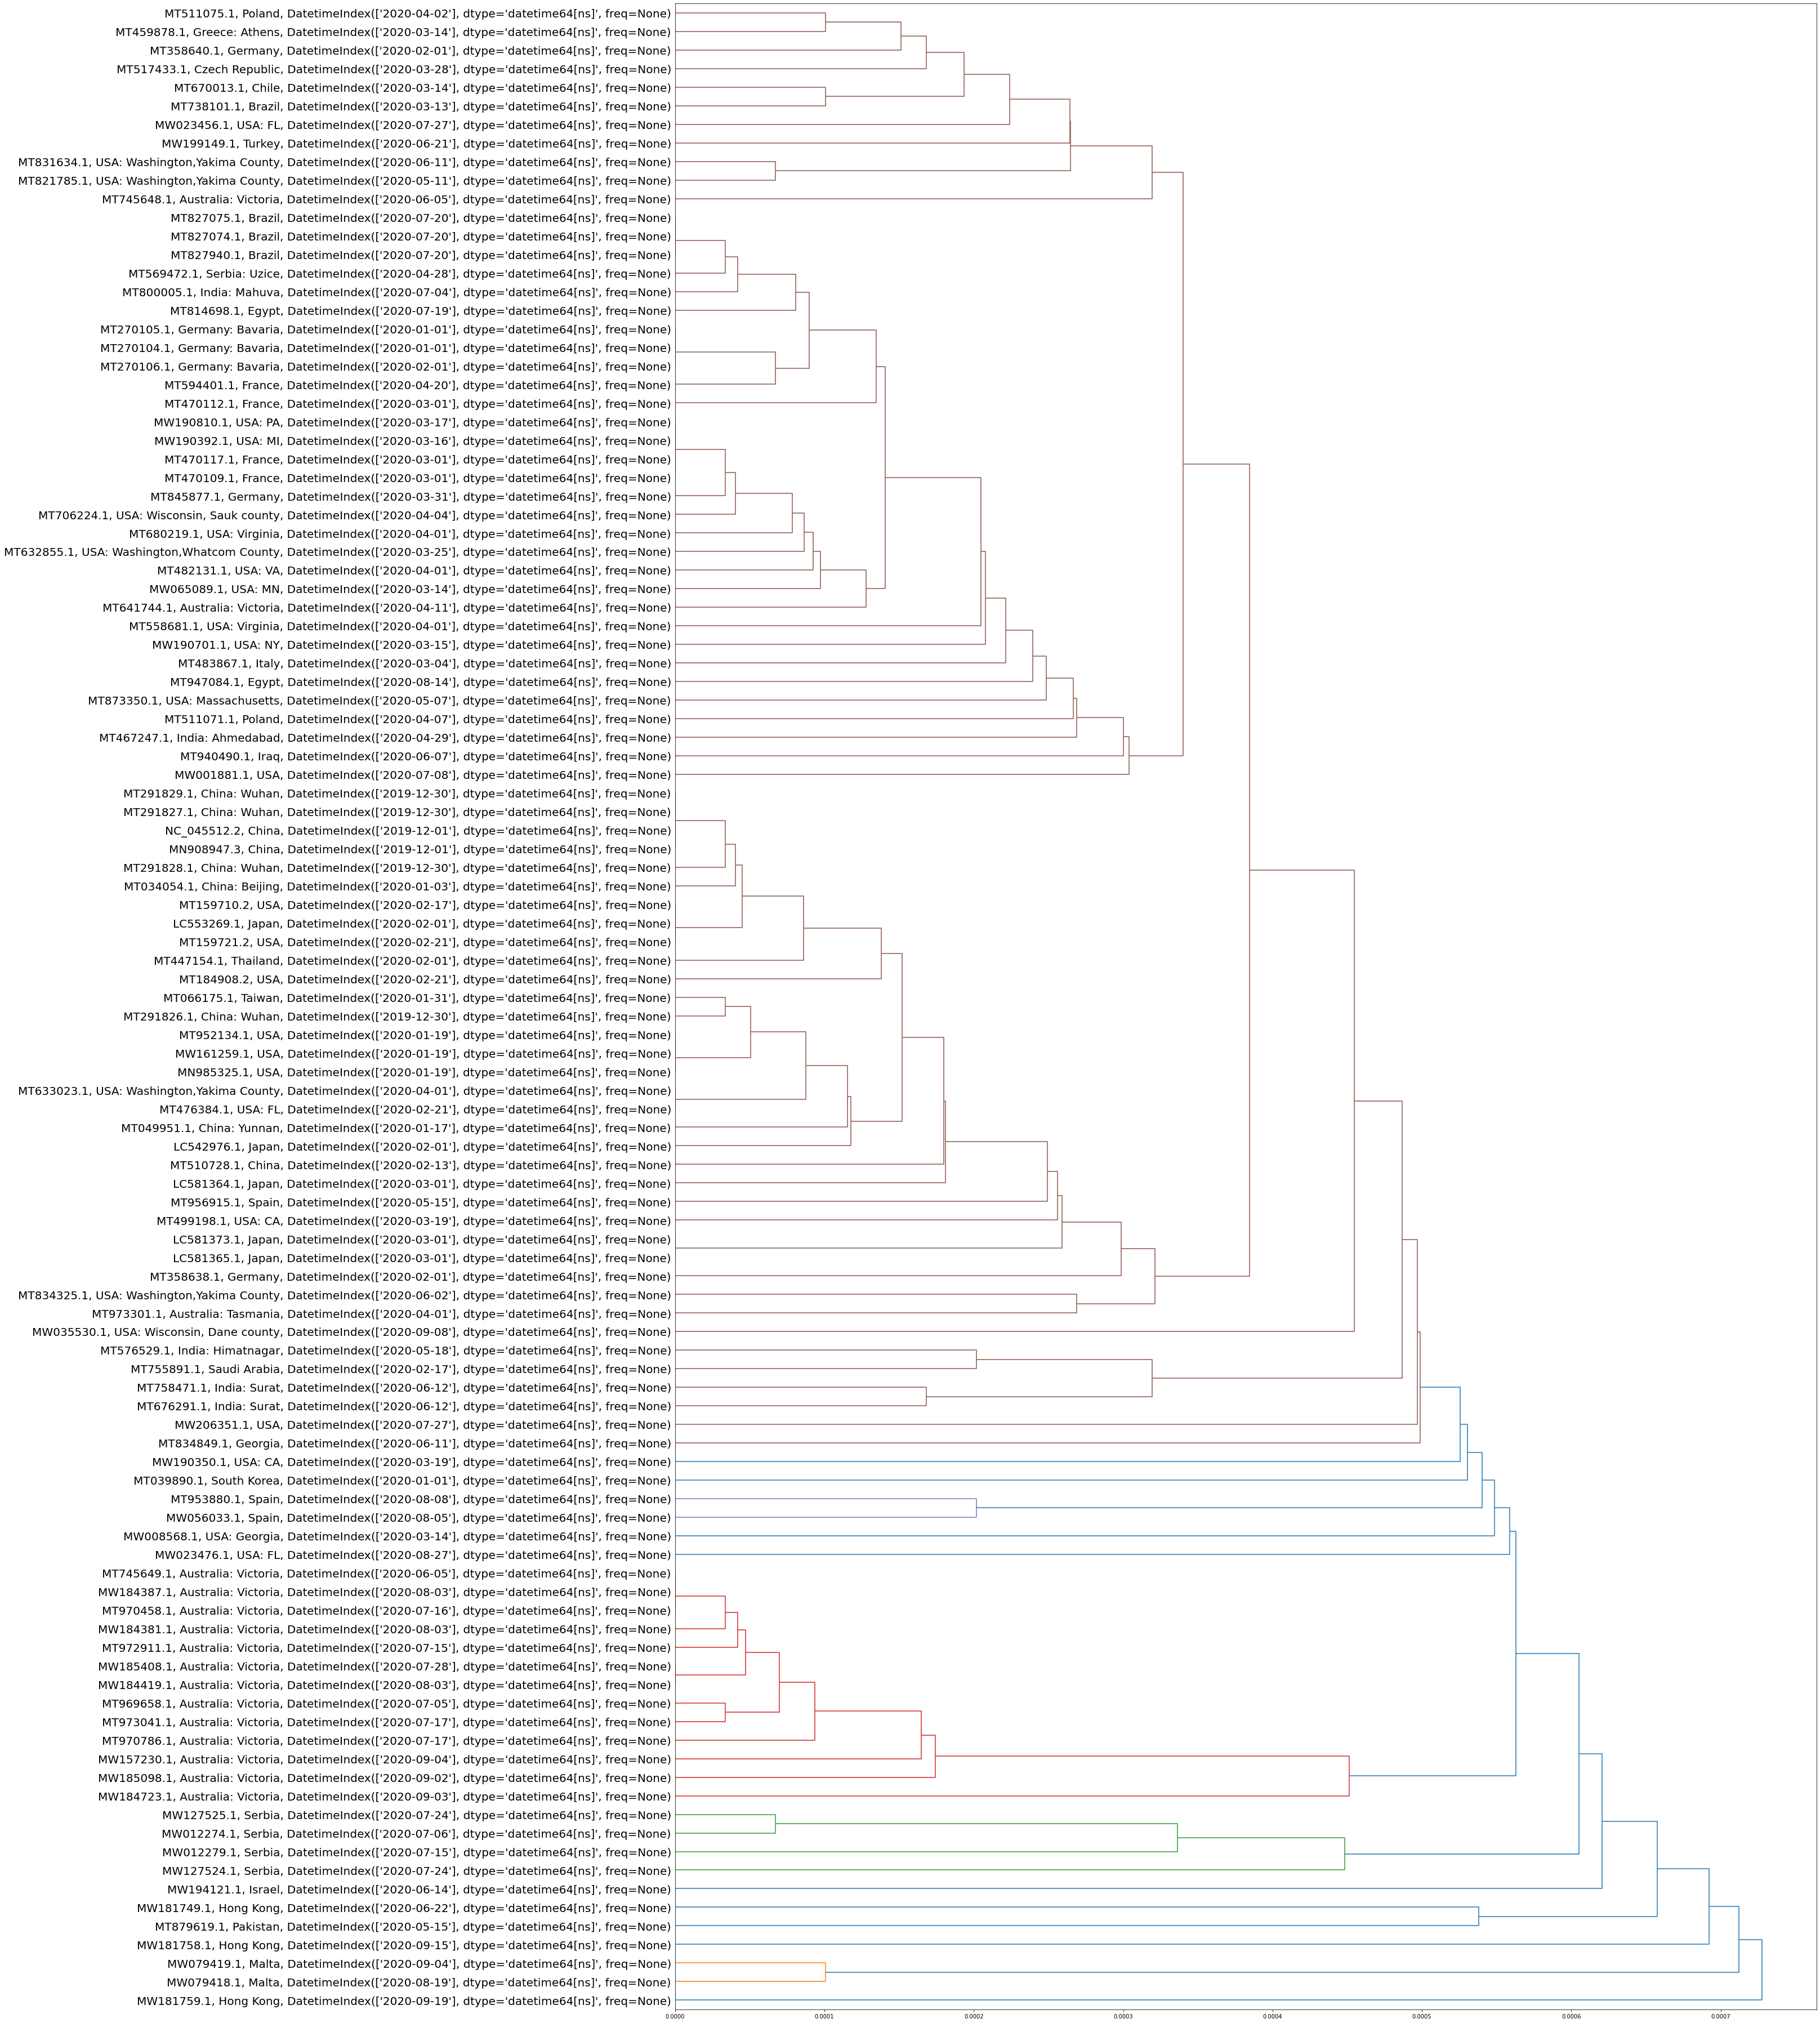

In [9]:
fig = plt.figure(figsize=(45, 50))
dn = dendrogram(distance_matrix, labels=labels, orientation='right', leaf_font_size=20)
plt.tight_layout()
plt.savefig('problem2.png')

In [10]:
dendrogram_comments = """
We can see the similarity of viruses from the same time period, also there are some similarities between the nearby countries
(for example Poland, Germany, France)
"""

## Problem 3a: Rate of mutation

One question we may want to ask ourselves is, "How fast is this virus actually evolving"? Can we empirically determine the speed of mutation? We can! Most biologists are very meticulous with their experiments and carefully document when any sample was collected. We can then take a bunch of viral genomes, select a reference genome (usually the first known occurrence of the virus), and calculate the number of mutations from the reference to the remaining viral genomes. We can then use this information in conjunction with the sample collection dates to estimate how fast the viruses are evolving.

**TASK:** Find the first collected instance of SARS-CoV-2 i.e., the virus with the earliest collection date. We'll use this as our reference virus. Calculate the genetic distance (using the Jukes-Cantor correction) from this starting sequence to all the other sequences and plot its dependence to the time elapsed from this starting point. Put genetic distance on the y-axis and time in days (the number of days since the starting point) on your x-axis. The earliest sequence -- starting point -- should be located at the origin (0, 0). Estimate the rate of mutation using linear regression and overlay your plot with the regression line. Save the resulting figure into `problem3a.png`. Report the slope of the line and save it into the `sars_cov_2_coeff` variable.
**[5 points]** 

Hint: check out `np.polyfit` to fit the linear regression curve.

In [11]:
def takeDateTimeElement(element):
    return element[1][0][1]

sarsCov2_records.sort(key=takeDateTimeElement)
sars_first_occ = sarsCov2_records[0]
print(sars_first_occ)

['MN908947.3', [[['Homo sapiens'], DatetimeIndex(['2019-12-01'], dtype='datetime64[ns]', freq=None), ['China']]], Seq('GTCACTCGGCTGCATGCTTAGTGCACTCACGCAGTATAATTAATAACTAATTAC...GCT')]


In [12]:
def calculate_distances(records, first_occ):
    genetic_distances = []
    time_distances = []
    for i in range(len(records)):
        distance_h = hamming(first_occ[2], records[i][2])
        distance_p = distance_h / len(first_occ[2])
        distance = jukes_cantor(distance_p)
        genetic_distances.append(distance)
        time_d = takeDateTimeElement(records[i]) - takeDateTimeElement(first_occ)
        number_of_days = time_d.days
        time_distances.append(number_of_days[0])
    return genetic_distances, time_distances

In [13]:
sars_genetic_distances, sars_time_distances = calculate_distances(sarsCov2_records[1:], sars_first_occ)        
sars_coef = np.polyfit(sars_time_distances, sars_genetic_distances, 1)
print(sars_coef)

[1.80157957e-06 4.10276481e-05]


In [14]:
sars_cov_2_coeff = 1.80157957e-06

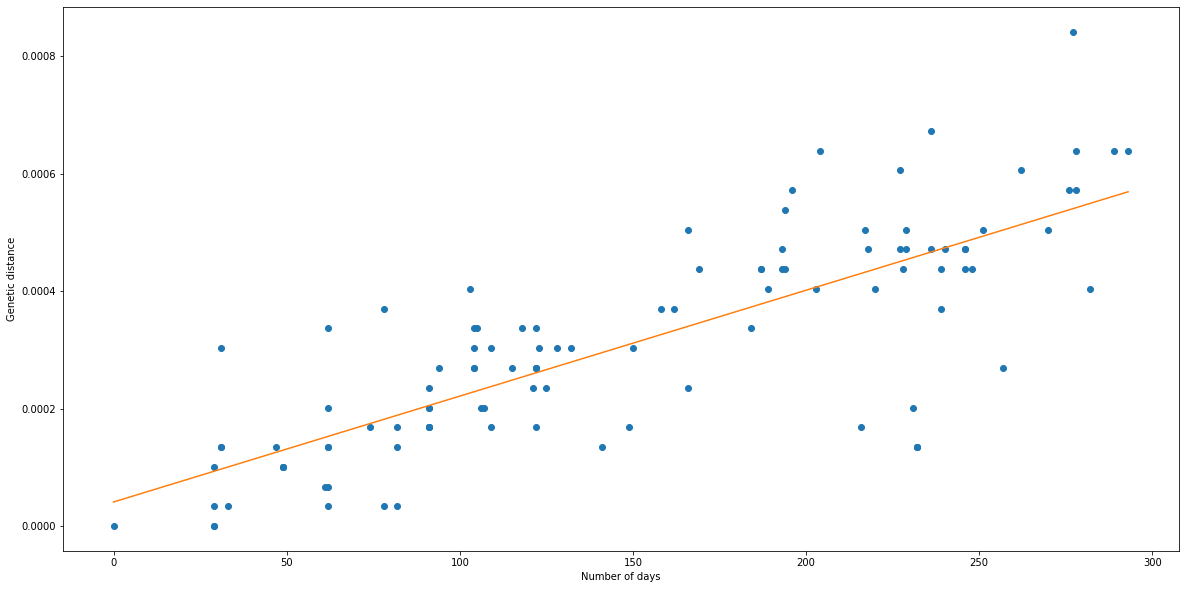

In [15]:
poly1d_fn = np.poly1d(sars_coef)
fig = plt.figure(figsize=(20, 10))
plt.plot(sars_time_distances, sars_genetic_distances, 'o')
plt.plot(sars_time_distances, poly1d_fn(sars_time_distances))
plt.xlabel('Number of days')
plt.ylabel('Genetic distance')
plt.savefig('problem3a.png', format='png')

## Problem 3b: Mutation rate in other viruses

Okay, we've estimated the regression slope to SARS-CoV-2. Now what? Does the plot indicate a fast mutation rate? Or a slow mutation rate? Or an average mutation rate? We really can't tell without a frame of reference. In this exercise, we will look at two more viruses from recent outbreaks, the Zaire ebolavirus, and Zika virus, and determine their rate of mutation. These will help us get some kind of reference for the speed at which viruses mutate.

**TASK:** Find the aligned sequences for Ebola and Zika virus in the accompanying fasta files. You will also need to download the sequence metadata from NCBI. As in 3a, estimate the slope of the regression line for each of the viruses. Since these viruses have been around for longer than SARS-CoV-2, they are more diverse and the distances between them may be larger. This can be observed if the reference sequence is at the origin, but the others start much higher i.e., the line fitting the remaining sequences doesn't go through the origin but is shifted higher up. In this case, ignore the reference sequence when fitting the regression lines. Report the slopes of both lines and save them to their corresponding variables, `ebola_coeff` and `zika_coeff`. Given this reference frame, how fast is SARS-CoV-2 mutating? Examine the ratios of the slopes. Can you find anything on the internet that would corroborate these rates of mutations? Write your observations into the `mutation_comments` variable.
**[5 points]** 

**Why these two reference viruses?** SARS-CoV-2 is in a unique position where it really is a worldwide phenomenon and warranted a huge global response. As such, SARS-CoV-2 is most likely the most well-documented and tracked virus of all time. Even five years ago, sequencing on this scale would have been impossible. This creates a problem when we want to compare the rate of mutation with other viruses. We need reference viruses that have gone through a similar lifecycle to SARS-CoV-2 and need to be recent enough such that there is sufficient sequencing data to properly estimate the slopes. Unfortunately for us (but thankfully for humanity), there are only a handful of viruses that fit this description (https://en.wikipedia.org/wiki/List_of_epidemics). Additionally, some developing countries still do not have the technological or economic capability to actually carry out this sequencing on a large scale, making reliable data to come by. We have chosen the Ebola virus and Zika virus, as their sequencing data is more or less reliable and plentiful enough.

In [16]:
ebola_records = load_records('data/ncbi-ebola.fasta')
ebola_records.sort(key=takeDateTimeElement)
ebola_first_occ = ebola_records[0]
ebola_genetic_distances, ebola_time_distances = calculate_distances(ebola_records[1:], ebola_first_occ)
ebola_coef = np.polyfit(ebola_time_distances, ebola_genetic_distances, 1)
print(ebola_coef)

[2.09004002e-06 6.27266806e-04]


In [17]:
zika_records = load_records('data/ncbi-zika.fasta')
zika_records.sort(key=takeDateTimeElement)
zika_first_occ = zika_records[0]
zika_genetic_distances, zika_time_distances = calculate_distances(zika_records[1:], zika_first_occ)
zika_coef = np.polyfit(zika_time_distances, zika_genetic_distances, 1)
print(zika_coef)

[7.52583811e-06 1.86987337e-03]


Text(0, 0.5, 'Genetic distance')

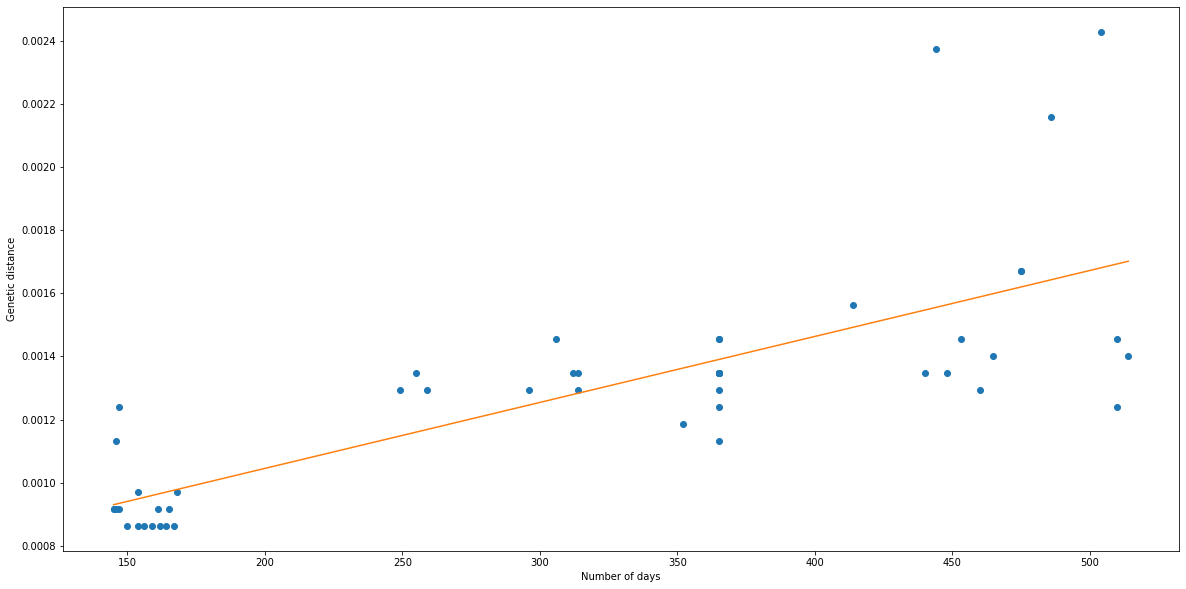

In [18]:
poly1d_fn = np.poly1d(ebola_coef)
fig = plt.figure(figsize=(20, 10))
plt.plot(ebola_time_distances, ebola_genetic_distances, 'o')
plt.plot(ebola_time_distances, poly1d_fn(ebola_time_distances))
plt.xlabel('Number of days')
plt.ylabel('Genetic distance')

Text(0, 0.5, 'Genetic distance')

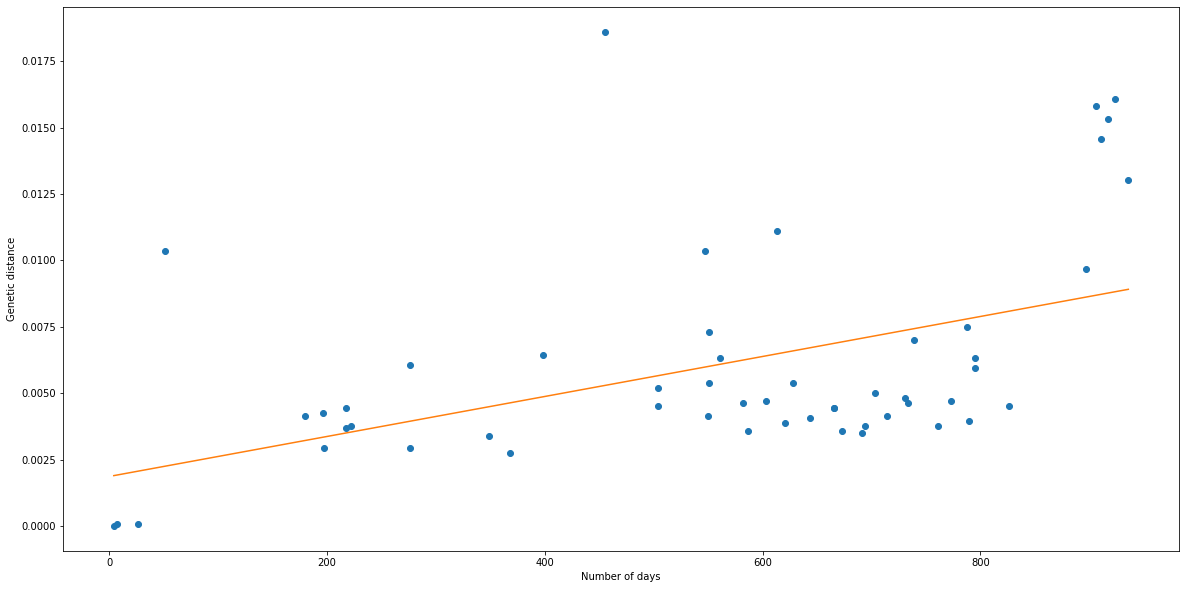

In [19]:
poly1d_fn = np.poly1d(zika_coef)
fig = plt.figure(figsize=(20, 10))
plt.plot(zika_time_distances, zika_genetic_distances, 'o')
plt.plot(zika_time_distances, poly1d_fn(zika_time_distances))
plt.xlabel('Number of days')
plt.ylabel('Genetic distance')

In [20]:
ebola_coeff = 2.09004002e-06
zika_coeff = 7.52583811e-06

mutation_comments = """
Interestingly, SARS-CoV-2 is mutating slower than Ebola and Zika virus.
"""

## Problem 4: Identifying variants

As the virus mutates, it inevitably evolves and proliferates around the world. Every so often, some mutations may prove especially beneficial to the spread of the virus, and this version of the virus spreads faster than other versions. When a version of a virus becomes especially prevalent inside a population, we call this a virus *variant*. Variants are nothing more than a naming scheme for viruses that have certain mutations. For instance, in Slovenia, we are currently predominantly dealing with the Delta variant. However, there are now said to be sub-variants of Delta. Or, if you have been keeping with the news cycle, you'll be aware of the new Omicron variant making its way around the world. Think of this as observing natural selection in real-time. Some viruses have mutations that enable them to spread more easily throughout our population, which inevitably leads to the demise of other virus variants, which are not good at spreading. This is survival of the fittest at the viral level, where, unfortunately, the fittest viruses seem to cause the most damage to us humans.

So, how do we identify variants? A variant is determined by a number of so-called *defining mutations*. Mutations can either be synonymous or nonsynonymous. Synonymous mutations are changes in nucleotide bases that result in the same encoded amino acid and are generally not interesting. Nonsynonymous mutations are nucleotide mutations that alter the amino acid sequence of a protein.

To determine mutations, we first have to select a reference genome, which we will say has no mutations. In most cases, this is the first known occurrence of the virus -- in our case -- the reference NCBI genome from Wuhan in 2019. Then, we align each viral genome of interest to this reference genome. All the differences between the reference genome and the genome of interest are said to be mutations. A common convention is to denote mutations using a short string e.g. *S:T 19 R*. The first part denotes the protein where the mutation has occurred. The second part is comprised of the actual mutation. For instance, *S:T 19 R* means that we are looking at a mutation on the S -- spike protein, where the original amino acid at location 19 was T -- threonine, which was changed to R -- arginine. The "-" symbol indicates a deletion (e.g. *S:H 69 -*). For a complete reference of SARS-CoV-2 mutations, you can take a look at https://covariants.org, and look through the different variants. We will not consider insertions in this homework, as it would only complicate our lives.

The folks over at the Clinical Institute of Special Laboratory Diagnostics have been kind enough to provide us with SARS-CoV-2 sequences from Slovenia for the past year and a half. In this homework, we will take a handful of these SARS-CoV-2 genomes from Slovenia and look at how the different variants spread throughout our country over time. We will again focus on the spike protein sequence as this will speed up computation. Additionally, the spike protein sequence is the most interesting in terms of variants, as mutations on the spike protein directly affect its ability to spread throughout our population and potentially get around our vaccination efforts.

**TASK**

You are given 756 SARS-CoV-2 spike protein sequences collected from Slovenia at various time points from the past year or so (*slo-sequences-S-prot.fasta*). We have pre-aligned these sequences to the reference Wuhan-2019 SARS-CoV-2 genome, so your only job is to determine which variant each sequence belongs to. We have also prepared a JSON file (*variants.json*) containing all the information on SARS-CoV-2 variants that you'll need in this homework. Use the variant names and nonsynonymous mutations defined in this file for your classification.

Your task is to look through each of the provided SARS-Cov-2 sequences and assign it to a variant. To assign a variant, count the number of mutations on the spike protein sequence. You should assign the variant which has the highest percentage of matching mutations to a given variant. If all the variants have a match rate lower than 50%, then you should assign the genome to the *UNKNOWN* class. If a sequence has no mutations, assign it to the *NO_MUTATIONS* class. Save your answers to `problem4-classification.csv`. This file should contain two columns. The first column should indicate the accession id, e.g., *EPI_ISL_635200*, while the second column should indicate the variant display name (as specified in variants.json), e.g., *20I (Alpha, V1)* or *21K (Omicron)*. The CSV file should have no header. **[5 points]**

After you have assigned all the sequences to a variant, create a plot showing the change of distribution over time. More concretely, we have given you up to 20 sequences per month. Calculate the percentage of each variant in each month, and plot the distribution over time. Your plots should resemble https://covariants.org/per-country, which you can use to validate your work. Note that your plot will probably have a lot of *UNKNOWN* viral assignments. Save your figure into `problem4.png`. **[5 points]** 

**Hints**: Use [`plt.stackplot`](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.stackplot.html) for plotting. You might also find the pandas [`Grouper`](https://pandas.pydata.org/docs/reference/api/pandas.Grouper.html) class helpful when calculating percentages per month.

**Notes**:

1. Due to the fast nature of the sequencing done in these sequences, some sequences may contain the character "X". This character does not denote some new amino acid but means that the sequencing was ambiguous and/or that the amino acid wasn't able to be determined. You should ignore any positions with the "X" character, and these should not count towards mutations.

2. You are welcome to come up with your own classification scheme if you like. I've filtered out some variants from `variants.json`, which are harder to assign, but you can find the full mutation list in https://github.com/hodcroftlab/covariants/blob/master/scripts/clusters.py. If you come up with your own classification scheme and are able to assign more variants than your classmates, you'll be awarded extra points.

3. Although you could perform the alignment yourself with the algorithms you implemented in Homework 2, in this exercise, we have already pre-aligned the viral genomes for you to avoid any long-running computation. In this homework, we will only consider substitutions and deletions, and we will ignore insertions. The reason is that insertions tend to complicate our lives and that almost all of the variants for SARS-CoV-2 aren't actually determined by insertions.

In [21]:
import json

f = open('data/variants.json')
variants = json.load(f)
f.close()

slo_sars_records = []
for record in SeqIO.parse("data/slo-sequences-S-prot.fasta", "fasta"):
    datetime = pd.to_datetime(record.id.split('|')[-1])
    slo_sars_records.append((record.id, record.seq, datetime))

In [22]:
with Entrez.efetch(db="nucleotide", id=sars_first_occ[0], rettype="gb") as handle:
    genome = SeqIO.read(handle, "genbank")
    for feature in genome.features:
        if feature.type == 'CDS' and 'gene' in feature.qualifiers and 'S' in feature.qualifiers['gene']:
            wuhan_spike_seq = feature.qualifiers['translation'][0]

print(wuhan_spike_seq)

MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDLFLPFFSNVTWFHAIHVSGTNGTKRFDNPVLPFNDGVYFASTEKSNIIRGWIFGTTLDSKTQSLLIVNNATNVVIKVCEFQFCNDPFLGVYYHKNNKSWMESEFRVYSSANNCTFEYVSQPFLMDLEGKQGNFKNLREFVFKNIDGYFKIYSKHTPINLVRDLPQGFSALEPLVDLPIGINITRFQTLLALHRSYLTPGDSSSGWTAGAAAYYVGYLQPRTFLLKYNENGTITDAVDCALDPLSETKCTLKSFTVEKGIYQTSNFRVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFSTFKCYGVSPTKLNDLCFTNVYADSFVIRGDEVRQIAPGQTGKIADYNYKLPDDFTGCVIAWNSNNLDSKVGGNYNYLYRLFRKSNLKPFERDISTEIYQAGSTPCNGVEGFNCYFPLQSYGFQPTNGVGYQPYRVVVLSFELLHAPATVCGPKKSTNLVKNKCVNFNFNGLTGTGVLTESNKKFLPFQQFGRDIADTTDAVRDPQTLEILDITPCSFGGVSVITPGTNTSNQVAVLYQDVNCTEVPVAIHADQLTPTWRVYSTGSNVFQTRAGCLIGAEHVNNSYECDIPIGAGICASYQTQTNSPRRARSVASQSIIAYTMSLGAENSVAYSNNSIAIPTNFTISVTTEILPVSMTKTSVDCTMYICGDSTECSNLLLQYGSFCTQLNRALTGIAVEQDKNTQEVFAQVKQIYKTPPIKDFGGFNFSQILPDPSKPSKRSFIEDLLFNKVTLADAGFIKQYGDCLGDIAARDLICAQKFNGLTVLPPLLTDEMIAQYTSALLAGTITSGWTFGAGAALQIPFAMQMAYRFNGIGVTQNVLYENQKLIANQFNSAIGKIQDSLSSTASALGKLQDVVNQNAQALNTLVKQLSSNFGAISSVLNDILSRLDKVEAEVQIDRLITGR

In [23]:
for record in slo_sars_records[0:1]:
    print(record)

('hCoV-19/Slovenia/751/2020|EPI_ISL_635200|2020-03-05', Seq('MFVFLVLLPLVSSQCVNLTTRTQLPPAYTNSFTRGVYYPDKVFRSSVLHSTQDL...YT*'), Timestamp('2020-03-05 00:00:00'))


In [24]:
mutations = []
for record in slo_sars_records:
    max = (0, '')
    count_g = 0
    for variant in variants:
        data = variants[variant]['mutations']['nonsynonymous']
        count = 0
        for d in data:
            gene = d['gene']
            left = d['left']
            right = d['right']
            position = d['pos']
            if position <= 1274:
                #print(wuhan_spike_seq[position-2:position+1], left+gene+right)
                if record[1][position-1] == gene:
                    count += 1
                    count_g += 1
        if max[0] < count:
            max = (count, variant)
    if count_g == 0:
        mutations.append([record[0], 'NO_MUTATIONS'])
    elif max[0] / count_g > 0.5:
        mutations.append([record[0], max[1]])
    else:
        mutations.append([record[0], 'UNKNOWN'])
   
mutations = np.array(mutations)
print(np.unique(mutations[:,1], return_counts=True))

(array(['21K.Omicron', 'Epsilon', 'UNKNOWN'], dtype='<U64'), array([  3,   1, 752], dtype=int64))


In [25]:
a = np.array([[1, 4], [2, 3]])
a[:, 0]

array([1, 2])

## Bonus problem: Pretty dendrograms

Flame wars are fought every day online as people argue between which programming language is better. These battles are never won or lost, as each side stubbornly sticks to their guns, not budging a single inch from their respective standpoints. Every few years, new contenders enter the fray and the world is ever more divided. In bioinformatics, it usually comes down to Python versus R (despite what Julia fans like to say, the Julia ecosystem is nowhere near complete enough to even begin to compete). Although we are, at this subject, clearly biased towards Python (we are making you complete these homeworks in Python after all), we still concede that R is better than Python at data visualization, particularly at drawing dendrograms.

**TASK:**

This bonus assignment is completely open-ended. We have by now drawn at least two dendrograms using scipy: in HW2 and in this homework in Problem 2. However, these dendrograms are not the most visually appealing. They are quick and dirty and get the job done. Your task is to implement prettier dendrogram drawing using Python's matplotlib. This can include one of the following:
- radial layout ([example 1](https://www.instituteofcaninebiology.org/uploads/1/9/6/9/19691109/2336926.png?797), [example 2](https://leilabattison.files.wordpress.com/2012/02/dn14392-1_1891.jpg))
- date-based layout ([example 1](https://nextstrain.org/ncov/global)). The dendrogram is constructed in the same way as before - using genetic distances, but notice how the branch lengths are now determined by date instead of length.

Make use of colors to highlight different dates, countries or regions. You have full creative freedom here.

Save your dendrogram into `problem-pretty-dendrogram.png`. Since this problem may require a fair bit of code, put your implementation in a new file named `pretty_dendrogram.py`. If it is apparent from your dendrogram that you put effort into the visualization and if it looks visually appealing, you'll automatically get full points. Visually appealing may seem subjective, but the examples above should serve as a guideline to what is "very visually appealing".

**[10 points]**